In [17]:
import pymc as pm
import arviz as az

from scipy.stats import beta, gamma
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

## 4.1 Inferring a mean and standard deviation

$$x\sim \mathcal{N}(\mu, 1/\lambda)$$

对高斯分布建模的过程关键在于先验分布的选择：
- $\mu$ 一般是均值为0，precision很低（比variance很大好）的高斯分布
- $\sigma$ 用固定范围内的均匀分布 Gelman（2006）；或者 $\lambda$ （精度）用Gamma分布

Notes：
- 高斯Gaussian分布的别称：正态Normal，中心Central，麦克斯韦Maxwellian
- 方差variances与精度precisions互为倒数，教材中标注/以及建模中更常用的是精度


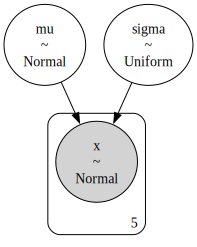

In [7]:
with pm.Model() as GaussianDist:
    x_obs = [0, 1, 2, 3, 4]
    mu = pm.Normal('mu', mu = 0, tau = 0.001)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    x = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
pm.model_to_graphviz(GaussianDist)

In [8]:
# Exercise 4.1.1
with GaussianDist:
    trace = pm.sample(10000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.993,1.194,-0.253,4.281,0.011,0.017,13086.0,11200.0,1.0
sigma,2.394,1.278,0.806,4.704,0.014,0.021,11286.0,10496.0,1.0


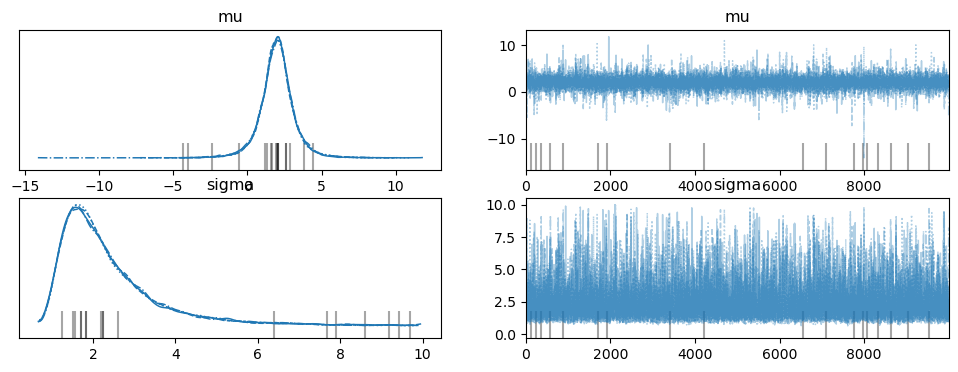

In [9]:
az.plot_trace(trace)
az.summary(trace)

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

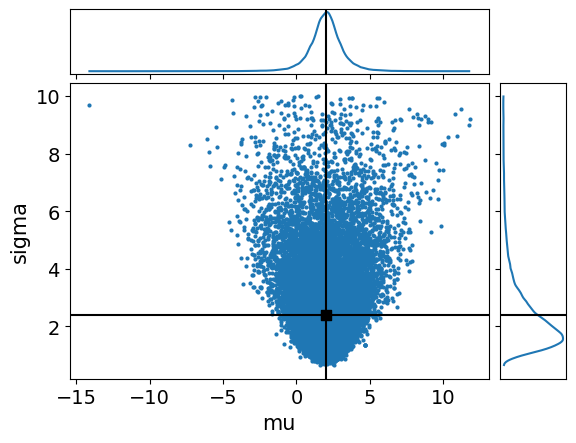

In [14]:
# Exercise 4.1.2
# 当sigma很小的时候，mu容许的变异性比较小
# 而对很大的sigma，mu也有比较大的变异性
az.plot_pair(trace, var_names = ['mu', 'sigma'], marginals = True, point_estimate='mean')

In [15]:
# Exercise4.1.3
with pm.Model() as GaussianMean:
    sigma = 1
    x_obs = [0, 1, 2, 3, 4]
    mu = pm.Normal('mu', mu = 0, tau = 0.001)
    x = pm.Normal('x', mu, sigma = sigma, observed=x_obs)
    trace_mu = pm.sample(1000)
az.summary(trace_mu)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.99,0.43,1.171,2.785,0.011,0.006,1436.0,2961.0,1.0


In [16]:
# Exercise4.1.4
with pm.Model() as GaussianMean:
    mu = 0
    x_obs = [0, 1, 2, 3, 4]
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    x = pm.Normal('x', mu, sigma = sigma, observed=x_obs)
    trace_mu = pm.sample(1000)
az.summary(trace_mu)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,3.357,1.465,1.461,6.137,0.073,0.07,393.0,411.0,1.02


## 4.2 The Seven Scientists

背景：七个科学家对同一个东西进行观测，我们希望根据测量结果推断真实测量的后验分布和每个科学家能力的后验概率

Note：
- $Gamma(0, 0)$ 的精度先验分布能够满足 $sigma$ 在对数尺度上的不变性
- 实际操作中用 $Gamma(0.001, 0.001)$ 或者稍微大一些的值近似
- 对贝叶斯来说，选对先验和选对数据同样重要（这是优点还是缺点呢

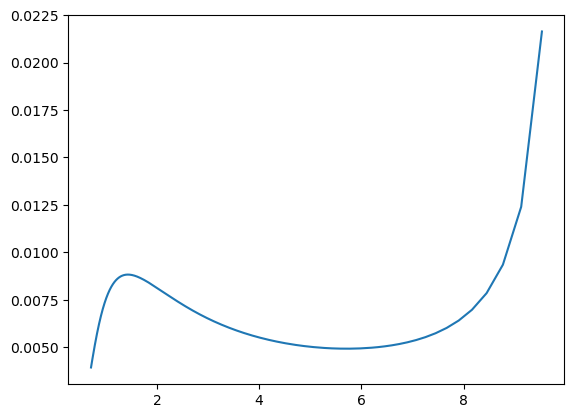

In [47]:
# sigma的先验分布
x_range = np.arange(0.01, 2.001, 0.001)
y = gamma.pdf(x_range, 0.01, 0.01)
plt.plot(1/np.sqrt(x_range), y * 2 * x_range**1.5)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


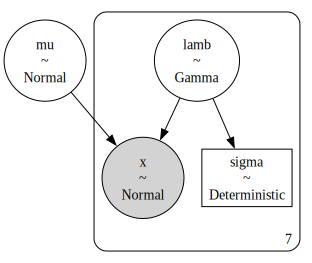

In [33]:
with pm.Model() as SevenScientist:
    x_obs = [-27.020, 3.570, 8.191, 9.898, 9.603,9.945, 10.056]
    mu = pm.Normal('mu', mu = 0, tau = 0.001)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = len(x_obs))
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    x = pm.Normal('x', mu = mu, tau = lamb, observed = x_obs)
    trace = pm.sample(10000)
pm.model_to_graphviz(SevenScientist)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.912,0.132,9.621,10.112,0.002,0.007,9193.0,7034.0,1.0


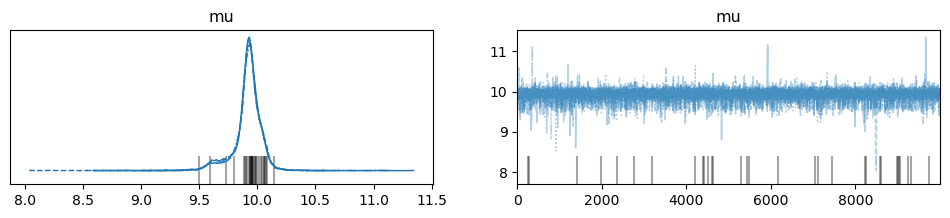

In [35]:
# Exercise 4.2.1
az.plot_trace(trace, var_names = ['mu'])
az.summary(trace, var_names = ['mu'])

In [38]:
az.summary(trace, var_names = ['sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],337.701,8830.021,8.657,508.686,78.139,4005.132,17220.0,11027.0,1.0
sigma[1],46.463,577.635,1.653,86.511,5.249,126.719,13656.0,10058.0,1.0
sigma[2],14.665,305.049,0.445,22.721,2.763,109.140,12508.0,9590.0,1.0
sigma[3],0.636,5.821,0.014,1.371,0.050,1.071,12426.0,12725.0,1.0
sigma[4],3.167,69.485,0.017,4.493,0.775,28.964,10738.0,9654.0,1.0
sigma[5],0.630,5.251,0.012,1.365,0.043,0.902,10737.0,11786.0,1.0
sigma[6],0.954,10.691,0.013,2.099,0.070,1.932,11416.0,11162.0,1.0


In [48]:
with pm.Model() as SevenScientistG001:
    x_obs = [-27.020, 3.570, 8.191, 9.898, 9.603,9.945, 10.056]
    mu = pm.Normal('mu', mu = 0, tau = 0.001)
    lamb = pm.Gamma('lamb', alpha = 0.01, beta = 0.01, shape = len(x_obs))
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    x = pm.Normal('x', mu = mu, tau = lamb, observed = x_obs)
    trace = pm.sample(10000)
az.summary(trace, var_names = ['mu'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.859,0.248,9.466,10.221,0.004,0.015,7717.0,4492.0,1.0


In [49]:
az.summary(trace, var_names = ['sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],261.988,3275.327,9.800,473.175,43.601,1249.189,13477.0,8991.0,1.0
sigma[1],70.368,2338.661,1.573,80.786,21.614,1083.679,18809.0,11184.0,1.0
sigma[2],8.169,50.259,0.074,19.976,0.445,8.364,11821.0,12059.0,1.0
sigma[3],3.319,130.627,0.038,2.875,1.986,64.826,13298.0,11164.0,1.0
sigma[4],2.444,29.447,0.048,4.232,0.276,6.150,14602.0,11466.0,1.0
sigma[5],1.515,18.733,0.037,3.055,0.188,7.253,12362.0,11108.0,1.0
sigma[6],1.505,12.489,0.040,3.496,0.101,3.595,10827.0,10096.0,1.0


In [52]:
# Exercise 4.2.2
## 真的对先验很敏感
with pm.Model() as SevenScientistU100:
    x_obs = [-27.020, 3.570, 8.191, 9.898, 9.603,9.945, 10.056]
    mu = pm.Normal('mu', mu = 0, tau = 0.001)
    # lamb = pm.Gamma('lamb', alpha = 0.01, beta = 0.01, shape = len(x_obs))
    sigma = pm.Uniform('sigma', lower = 0, upper = 100, shape = len(x_obs))
    x = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(10000)
az.summary(trace, var_names = ['mu'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
There were 4977 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,8.529,4.33,-0.056,15.247,0.062,0.14,7745.0,6280.0,1.0


In [54]:
az.summary(trace, var_names = ['sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],54.476,23.068,20.295,97.997,0.341,0.170,4620.0,2318.0,1.0
sigma[1],30.914,26.184,0.228,83.353,0.388,0.267,5372.0,4795.0,1.0
sigma[2],24.686,25.880,0.106,78.944,0.360,0.221,3724.0,3904.0,1.0
sigma[3],23.224,25.647,0.119,77.661,0.339,0.195,1889.0,733.0,1.0
sigma[4],22.712,25.697,0.146,77.749,0.365,0.203,1934.0,904.0,1.0
sigma[5],22.654,25.437,0.073,77.009,0.317,0.198,2696.0,1605.0,1.0
sigma[6],24.350,26.129,0.057,78.804,0.472,0.321,1773.0,898.0,1.0


## 4.3 Repeated Measurement of IQ



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


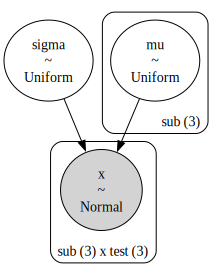

In [98]:
coords = {'sub': ["A", "B", "C"], 'test': ["T1", "T2", "T3"]}
with pm.Model(coords=coords) as IQTest:
    x_obs = np.array([[90, 95, 100], [105, 110, 115], [150, 155, 160]])
    sigma = pm.Uniform('sigma', lower = 0, upper = 100)
    mu = pm.Uniform('mu', lower = 0, upper = 300, dims = "sub")
    x = pm.Normal('x', mu = mu[:, np.newaxis], sigma = sigma, observed = x_obs, dims = ("sub", "test"))
    trace = pm.sample(2000)
pm.model_to_graphviz(IQTest)

In [99]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,6.554,2.752,2.892,11.429,0.058,0.077,2520.0,3229.0,1.0
mu[A],94.913,4.219,86.865,103.027,0.059,0.106,5632.0,3232.0,1.0
mu[B],109.963,4.125,101.775,117.294,0.060,0.104,5318.0,3617.0,1.0
mu[C],154.961,4.152,147.490,163.133,0.055,0.087,6200.0,4551.0,1.0


In [100]:
# Exercise 4.3.1
## 先验信息使得数据更接近100
coords = {'sub': ["A", "B", "C"], 'test': ["T1", "T2", "T3"]}
with pm.Model(coords=coords) as IQTest:
    x_obs = np.array([[90, 95, 100], [105, 110, 115], [150, 155, 160]])
    sigma = pm.Uniform('sigma', lower = 0, upper = 100)
    mu = pm.Normal('mu', mu = 100, sigma = 15, dims = "sub")
    x = pm.Normal('x', mu = mu[:, np.newaxis], sigma = sigma, observed = x_obs, dims = ("sub", "test"))
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[A],95.444,4.623,87.002,103.979,0.083,0.152,3686.0,2564.0,1.0
mu[B],109.174,4.423,100.916,117.562,0.079,0.112,3369.0,2264.0,1.0
mu[C],150.187,6.692,138.497,159.519,0.174,0.318,2314.0,1402.0,1.0
sigma,7.689,4.586,2.878,14.739,0.137,0.313,1523.0,1336.0,1.0


In [101]:
# Exercise 4.3.2
# 当数据更集中（variance更小）的时候，先验的影响就没那么大了
coords = {'sub': ["A", "B", "C"], 'test': ["T1", "T2", "T3"]}
with pm.Model(coords=coords) as IQTest:
    x_obs = np.array([[94, 95, 96], [109, 110, 111], [154, 155, 156]])
    sigma = pm.Uniform('sigma', lower = 0, upper = 100)
    mu = pm.Normal('mu', mu = 100, sigma = 15, dims = "sub")
    x = pm.Normal('x', mu = mu[:, np.newaxis], sigma = sigma, observed = x_obs, dims = ("sub", "test"))
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[A],95.011,0.830,93.537,96.583,0.011,0.022,6770.0,3909.0,1.0
mu[B],109.966,0.852,108.492,111.579,0.011,0.029,5903.0,3418.0,1.0
mu[C],154.821,0.845,153.316,156.387,0.012,0.025,5732.0,3436.0,1.0
sigma,1.320,0.594,0.605,2.284,0.013,0.029,2800.0,2998.0,1.0


In [102]:
# Exercise 4.3.2
coords = {'sub': ["A", "B", "C"], 'test': ["T1", "T2", "T3"]}
with pm.Model(coords=coords) as IQTest:
    x_obs = np.array([[94, 95, 96], [109, 110, 111], [154, 155, 156]])
    sigma = pm.Uniform('sigma', lower = 0, upper = 100)
    mu = pm.Uniform('mu', lower = 0, upper = 300, dims = "sub")
    x = pm.Normal('x', mu = mu[:, np.newaxis], sigma = sigma, observed = x_obs, dims = ("sub", "test"))
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.315,0.575,0.607,2.236,0.013,0.035,2282.0,2122.0,1.0
mu[A],95.038,0.861,93.533,96.651,0.014,0.033,3919.0,3385.0,1.0
mu[B],109.990,0.823,108.484,111.555,0.010,0.023,6194.0,3907.0,1.0
mu[C],154.999,0.835,153.410,156.500,0.011,0.021,5945.0,4207.0,1.0
